In [1]:
import RPi.GPIO as GPIO
import gpiozero
import time
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

# READ THIS SO YOU UNDERSTAND THE CODE

- This contains classes for the robot and controller. I used Michael's code (DifferentialRobot, RobotController) in the ECE4191 repo (located in robot_navigation_and_control.ipynb) as a starting point, then built off of it.
- Hence, I'd probably recommend you look at the ECE4191 repo first to understand the basics of the robot and controller classes.
- The main difference is that I've added a few more methods to the robot class and added pin initialisations, and I've added a new PID method to the controller class which allows us to use a D term if we need (currently unused, set to 0.)
- Please ask if you don't understand anything - I've tried to be extremely detailed in the comments

In [2]:
###################################################### Defining our Constants ######################################################
# Encoder pins
# ML = motor left, MR = motor right
GPIO.cleanup()
GPIO.setmode(GPIO.BCM)

ML_ENC_A = 15 # yellow encoder c 23
ML_ENC_B = 14 # white encoder c 24

MR_ENC_A = 24 # yellow encoder c
MR_ENC_B = 23 # white encoder c

# The number of encoder steps per revolution. This was calculated according to the math that Lacie had in Notion.
MAX_ENC_STEPS = 3600

# Motor Pins
ML_IN1 = 17 # IN1 
ML_IN2 = 27 # IN2
ML_ENA = 11 # Used for PWM

MR_IN3 = 22 # IN3
MR_IN4 = 10 # IN4
MR_ENB = 9 # Used for PWM

# Physical dimensions
WHEEL_RADIUS = 0.028 # meters
WHEEL_SEP = 0.222 # meters

# wheel separation measurement (ASCII art)
"""
    <------- l ------->
    |                 |
 ___|___           ___|___
|       |         |       |
|   O   |         |   O   |
|_______|         |_______|
    ^                 ^
    |                 |
  Left wheel       Right wheel
  center            center
"""


/tmp/ipykernel_1958/1530775278.py:4: RuntimeWarning: No channels have been set up yet - nothing to clean up!  Try cleaning up at the end of your program instead!
  GPIO.cleanup()


In [3]:

###################################################### Class Definitions ######################################################


class DiffDriveRobot:
    def __init__(
            self, 
            dt=0.1, 
            motor_calibration_factor=0, # deprecated
            wheel_radius=WHEEL_RADIUS, 
            wheel_sep=WHEEL_SEP,
            max_enc_steps=MAX_ENC_STEPS,
            ml_pwm=ML_ENA,
            mr_pwm=MR_ENB,
            ml_in1=ML_IN1,
            ml_in2=ML_IN2,
            mr_in3=MR_IN3,
            mr_in4=MR_IN4,
            ml_encA=ML_ENC_A,
            ml_encB=ML_ENC_B,
            mr_encA=MR_ENC_A,
            mr_encB=MR_ENC_B
    ):
        self.x = 0.0  # x-position, meters
        self.y = 0.0  # y-position, meters
        self.th = 0.0  # orientation, angle in radians
        
        self.wl = 0.0  # rotational velocity left wheel, rad/s
        self.wr = 0.0  # rotational velocity right wheel, rad/s
        
        self.dt = dt # time delta in seconds. The control loop runs every dt. Faster means the control loop runs more often. We can increase this to reduce CPU load on our robot.
        self.r = wheel_radius # wheel radius in meters.
        self.l = wheel_sep # wheel separation in meters
        self.max_enc_steps = max_enc_steps # steps in the encoder per revolution
        self.motor_calibration_factor = motor_calibration_factor  # deprecated

        # Pin numbers
        self.motor_L_in1 = ml_in1 # Input 1 (motor left)
        self.motor_L_in2 = ml_in2 # Input 2 (motor left)
        self.motor_R_in3 = mr_in3 # Input 3 (motor right)
        self.motor_R_in4 = mr_in4 # Input 4 (motor right)
        GPIO.setup(self.motor_L_in1, GPIO.OUT)
        GPIO.setup(self.motor_L_in2, GPIO.OUT)
        GPIO.setup(self.motor_R_in3, GPIO.OUT)
        GPIO.setup(self.motor_R_in4, GPIO.OUT)      
        
        # Initialize encoders
        self.ML_ENC = gpiozero.RotaryEncoder(a=ml_encA, b=ml_encB, max_steps=max_enc_steps, wrap=True)
        self.MR_ENC = gpiozero.RotaryEncoder(a=mr_encA, b=mr_encB, max_steps=max_enc_steps, wrap=True)
        self.ml_enc_steps = 0 # left motor encoder value (AKA shaft angle) in steps. Note, this is NOT in radians. It counts from 0 -> MAX_ENC_STEPS -> -MAX_ENC_STEPS (wraps around to -ve value)
        self.mr_enc_steps = 0 # right motor encoder value (AKA shaft angle) in steps. 

        # Initialize motor control pins
        GPIO.setup(ml_pwm, GPIO.OUT)
        GPIO.setup(mr_pwm, GPIO.OUT)
        self.motor_L_pwm = GPIO.PWM(ml_pwm, 1000)  # 1000 Hz frequency. This works well for our motor. Remember that motor speed is controlled by varying the duty cycle of our PWM frequency, and not the frequency itself. 
        self.motor_R_pwm = GPIO.PWM(mr_pwm, 1000)
        self.motor_L_pwm.start(0)
        self.motor_R_pwm.start(0)
    '''
    This method calculates the change in encoder steps between the current and previous time step.
    The logic might seem complicated but this is to deal with the wraparound in value (from 0 -> MAX_ENC_STEPS -> -MAX_ENC_STEPS) that the encoder values have.
    e.g. for the first rotation, the encoder goes from 0 to 3600, then for every rotation thereafter, it goes from -3600 to 3600, then wraps around again.
    '''
    def get_encoder_delta(self, curr_value, prev_value):
        raw_delta = curr_value - prev_value
        delta = raw_delta
        wraparound_thresh = np.ceil((2*self.max_enc_steps + 1) / 2)
        
        if raw_delta > wraparound_thresh:
            delta = raw_delta - (2*self.max_enc_steps+1)
        elif raw_delta < -wraparound_thresh:
            delta = raw_delta + (2*self.max_enc_steps+1)
        
        return delta
            
    
    # Wheel velocities in radians/sec
    '''
    This method reads the encoder values and calculates the wheel velocities in rad/s.
    It uses the get_encoder_delta method to calculate the change in encoder steps between the current and previous time step.
    It then converts this change in steps to radians, and then to radians per second.
    '''
    def read_wheel_velocities(self, dt=None):
        if not dt:
            dt = self.dt
        ml_enc_now = self.ML_ENC.steps
        mr_enc_now = self.MR_ENC.steps

        # Calculate change in steps, accounting for wrap-around
        ml_enc_delta = self.get_encoder_delta(ml_enc_now, self.ml_enc_steps)
        mr_enc_delta = self.get_encoder_delta(mr_enc_now, self.mr_enc_steps)

        # Convert step change to radians
        ml_delta_rad = ml_enc_delta / self.max_enc_steps * 2 * np.pi 
        mr_delta_rad = mr_enc_delta / self.max_enc_steps * 2 * np.pi

        # Calculate velocities
        self.wl = ml_delta_rad / dt # rad/s
        self.wr = mr_delta_rad / dt # rad/s

        # Update previous steps
        self.ml_enc_steps = ml_enc_now
        self.mr_enc_steps = mr_enc_now

        return self.wl, self.wr
  
    '''
    This method sets the motor speed based on the duty cycle provided. 
    It also sets the direction of the motor based on the sign of the duty cycle.
    The duty cycle is the percentage of time the motor is on, and it MUST be a value between -1 and 1.
    '''
    def set_motor_speed(self, left_duty_cycle, right_duty_cycle, apply_calibration_factor=True):      
        # Set direction
        GPIO.output(self.motor_L_in1, GPIO.HIGH if left_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_L_in2, GPIO.LOW if left_duty_cycle >= 0 else GPIO.HIGH)
        GPIO.output(self.motor_R_in3, GPIO.HIGH if right_duty_cycle >= 0 else GPIO.LOW)
        GPIO.output(self.motor_R_in4, GPIO.LOW if right_duty_cycle >= 0 else GPIO.HIGH)
        if apply_calibration_factor:
            if self.motor_calibration_factor < 0:  # Left motor is faster
                right_duty_cycle *= (1 + abs(self.motor_calibration_factor))
            elif self.motor_calibration_factor > 0:  # Right motor is faster
                left_duty_cycle *= (1 + self.motor_calibration_factor)
            
            # Find the maximum absolute duty cycle
            max_duty = max(abs(left_duty_cycle), abs(right_duty_cycle))

            # If max_duty is greater than 1, scale both duty cycles
            if max_duty > 1:
                left_duty_cycle /= max_duty
                right_duty_cycle /= max_duty
            
        # Set speed
        self.motor_L_pwm.ChangeDutyCycle(abs(left_duty_cycle) * 100)
        self.motor_R_pwm.ChangeDutyCycle(abs(right_duty_cycle) * 100)


    '''
    This method calculates the linear and angular velocity of the robot based on the wheel velocities.
    It uses the formulae for differential drive robots to calculate the linear and angular velocity.
    This is pretty much identical to Michael's code in the ECE4191 repo.
    '''
    def base_velocity(self, wl, wr):
        v = (wl * self.r + wr * self.r) / 2.0 # linear velocity, m/s, +ve is forward
        w = -(wl * self.r - wr * self.r) / self.l # angular velocity, rad/s, +ve is CCW. Note that the negative sign
        # is due to the way the motors are oriented, and so we need it to 'correct' our w calculation
        # so that +ve w is CCW, adhering to convention.
        return v, w
    
    
    """
    This method updates the robot's pose (x, y, theta) based on the wheel velocities.
    It uses the base_velocity method to calculate the linear and angular velocity of the robot.
    It then uses these velocities to update the robot's pose (x, y, theta) based on the kinematic equations.
    """
    def pose_update(self, duty_cycle_ml, duty_cycle_mr, dt=None, apply_calibration_factor=False):
        if not dt:
            dt = self.dt
            
        self.set_motor_speed(duty_cycle_ml, duty_cycle_mr, apply_calibration_factor)
        wl, wr = self.read_wheel_velocities() # get wheel velocities in rad/s
        v, w = self.base_velocity(wl, wr)
        
        self.x = self.x + dt * v * np.cos(self.th)
        self.y = self.y + dt * v * np.sin(self.th)
        self.th = self.th + w * dt
        
        return self.x, self.y, self.th

    
class RobotController:
    
    def __init__(self, Kp=0.2, Ki=0.0, Kd=0, wheel_radius=WHEEL_RADIUS, wheel_sep=WHEEL_SEP):
        
        self.Kp = Kp # Proportional gain
        self.Ki = Ki # Integral gain
        self.Kd = Kd # Derivative gain (I don't think we'll need this but we'll see)
        self.r = wheel_radius
        self.l = wheel_sep
        self.e_sum_l = 0 # the accumulated sum of the errors for the left wheel over time
        self.e_sum_r = 0 # the accumulated sum of the errors for the right wheel over time
        self.e_l_prev = 0 # the previous error for the left wheel, just for the previous iteration of the control loop
        self.e_r_prev = 0  # the previous error for the right wheel, just for the previous iteration of the control loop
    
    """
    I wrote this method as part of an experiment to see what was wrong (and still seems wrong) with the PI controller.
    - Essentially, with our current PI controller, even if the wheel error is large (e.g. the wheel is spinning much faster than it should be), the duty cycle is still very large, above 1, meaning it doesn't slow down and also keeps being 'saturated' at 1.
    - If you have a look at Michael's p_control method or my PID_control method, you'll see that they both 'clamp' or cap the duty cycles to ensure they're within the range of -1 to 1. This means that even if the left and right duty cycle values are both different values that are above or below 1, e.g. 1.57 and 2.3, they still get output as 1. This means that the relationship between the two duty cycles also gets lost, and we end up with 1 and 1 for left and right motor duty cycles.
    - And so, for my experiment, I decided to remove the duty cycle 'clamping' or cap in the p_control method and use this method instead to scale the duty cycles to be within 1 or -1, but still retain their proportionality to each other.
        - So for the previous example, instead of 1.57 and 2.3 getting turned into 1 and 1, they'd get turned into 0.68 and 1.
        - And this actually seemed to work somewhat! But you'll notice that I commented out the code that uses this method in the pid_control method as I was testing something else today (Friday 23/08/2024). 
    - Feel free to reenable this and modify pid_control and see what happens.
    """
    def scale_velocities(self, duty_cycle_l, duty_cycle_r):
            
        # Find the maximum absolute duty cycle
        max_duty = max(abs(duty_cycle_l), abs(duty_cycle_r))

        # If max_duty is greater than 1, scale both duty cycles
        if max_duty > 1:
            duty_cycle_l /= max_duty
            duty_cycle_r /= max_duty

        return duty_cycle_l, duty_cycle_r
    
    """
    This p_control method is pretty much identical to Michael's p_control in the ECE4191 repo, except that it actually integrates the error over time. We're not using this, instead we're using the method below.
    """
#     def p_control(self, w_desired, w_measured, e_sum, dt):
#         error = w_desired - w_measured
#         p_term = self.Kp * error
#         i_term = self.Ki * e_sum * dt  # Note: Integrate error over time
# #         duty_cycle = min(max(-1, p_term + i_term), 1)
#         duty_cycle = p_term + i_term
#         e_sum = e_sum + error * dt  # Accumulate error over actual time
        
#         return duty_cycle, e_sum
    
    """
    This is just the p_control method with an added d term that we're currently not using. I was testing it out to see if it would help with the wheel control, but it didn't seem to do much.
    """
    def pid_control(self, w_desired, w_measured, e_sum, last_error, dt):
        error = w_desired - w_measured
        p_term = self.Kp * error
        i_term = self.Ki * e_sum * dt
        d_term = self.Kd * (error - last_error) / dt

        duty_cycle = p_term + i_term + d_term
#         duty_cycle = min(max(-1, duty_cycle), 1)

#         # Anti-windup
#         if abs(duty_cycle) < 1:
#             e_sum = e_sum + error * dt
        e_sum = e_sum + error * dt  # Accumulate error over actual time

        return duty_cycle, e_sum, error

    """
    This is the main method that we use to control the robot's motion. It takes in the desired linear and angular velocities, and the measured wheel velocities, and calculates the duty cycles for the left and right motors.
    It uses the pid_control method to calculate the duty cycles.
    - I think this is where the issue is coming from, where we input a v_desired of 0.5m/s but we still get something like 2m/s coming out of the motors. Please help me.
    """
    def drive(self, v_desired, w_desired, wl, wr, dt):
        # v_desired: m/s, w_desired (rotation): rad/s
        # wl and wr (wheel ang. vel. for left and right): rad/s
        
        wl_desired = (v_desired + self.l*w_desired/2)/self.r # rad/s
        wr_desired = (v_desired - self.l*w_desired/2)/self.r # rad/s
        print(f"wl_des: {wl_desired}, wr_des: {wr_desired}")
        
#         duty_cycle_l, self.e_sum_l = self.p_control(wl_desired, wl, self.e_sum_l, dt)
#         duty_cycle_r, self.e_sum_r = self.p_control(wr_desired, wr, self.e_sum_r, dt)
        
            
        duty_cycle_l, self.e_sum_l, self.e_l_prev = self.pid_control(wl_desired, wl, self.e_sum_l, self.e_l_prev, dt)
        duty_cycle_r, self.e_sum_r, self.e_r_prev = self.pid_control(wr_desired, wr, self.e_sum_r, self.e_r_prev, dt)
        
        
        # Normalise duty cycles to 1
        duty_cycle_l, duty_cycle_r = self.scale_velocities(duty_cycle_l, duty_cycle_r)

        return duty_cycle_l, duty_cycle_r
    
    
    

In [4]:
"""
Just initalising the robot. The argument is dt, or how often the robot control loop should run. See the robot controller class or the below control loop for more explanation.
"""
GPIO.setwarnings(False)
robot = DiffDriveRobot(0.05)

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.76, w_actual: 2.79
duty cycle l: 1.00, r: 0.99
Position: (1.71, 0.08), Orientation: 0.09

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: -69.01, w_actual: -75.82
duty cycle l: 0.92, r: 1.00
Position: (1.71, 0.08), Orientation: 0.09

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 1.01, w_actual: 0.84
duty cycle l: 0.98, r: 1.00
Position: (1.72, 0.08), Orientation: 0.09

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 1.85, w_actual: 1.92
duty cycle l: 1.00, r: 0.99
Position: (1.73, 0.08), Orientation: 0.09

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 1.92, w_actual: 2.27
duty cycle l: 1.00, r: 0.95
Position: (1.73, 0.08), Orientation: 0.09

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.44, w_actual: 2.41
duty cycle l: 0.99, r: 1.00
Position: (2.06, 0.12), Orientation: 0.13

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.62, w_actual: 2.51
duty cycle l: 0.98, r: 1.00
Position: (2.06, 0.12), Orientation: 0.13

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.58, w_actual: 2.58
duty cycle l: 1.00, r: 1.00
Position: (2.07, 0.12), Orientation: 0.13

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.37, w_actual: 2.51
duty cycle l: 1.00, r: 0.98
Position: (2.08, 0.12), Orientation: 0.13

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.27, w_actual: 2.55
duty cycle l: 1.00, r: 0.96
Position: (2.09, 0.12), Orientation: 0.13

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.62, 

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.51, w_actual: 2.48
duty cycle l: 0.99, r: 1.00
Position: (2.41, 0.17), Orientation: 0.17

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.58, w_actual: 2.48
duty cycle l: 0.98, r: 1.00
Position: (2.42, 0.17), Orientation: 0.17

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.44, w_actual: 2.44
duty cycle l: 1.00, r: 1.00
Position: (2.42, 0.17), Orientation: 0.17

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.30, w_actual: 2.44
duty cycle l: 1.00, r: 0.98
Position: (2.43, 0.17), Orientation: 0.18

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.27, w_actual: 2.51
duty cycle l: 1.00, r: 0.97
Position: (2.44, 0.17), Orientation: 0.18

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.58, 

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.48, w_actual: 2.34
duty cycle l: 0.98, r: 1.00
Position: (2.76, 0.24), Orientation: 0.19

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.41, w_actual: 2.37
duty cycle l: 1.00, r: 1.00
Position: (2.77, 0.24), Orientation: 0.19

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.34, w_actual: 2.48
duty cycle l: 1.00, r: 0.98
Position: (2.77, 0.24), Orientation: 0.20

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.27, w_actual: 2.51
duty cycle l: 1.00, r: 0.97
Position: (2.78, 0.24), Orientation: 0.20

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.44, w_actual: 2.58
duty cycle l: 1.00, r: 0.98
Position: (2.79, 0.24), Orientation: 0.20

wl_des: 8.928571428571429, wr_des: 8.928571428571429
v_des: 0.50, w_des: 0.00, v_actual: 2.86, 

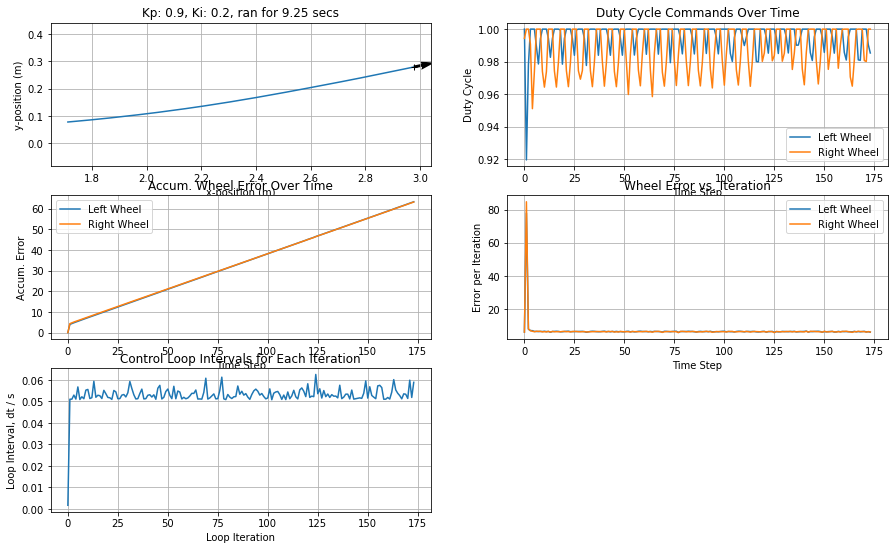

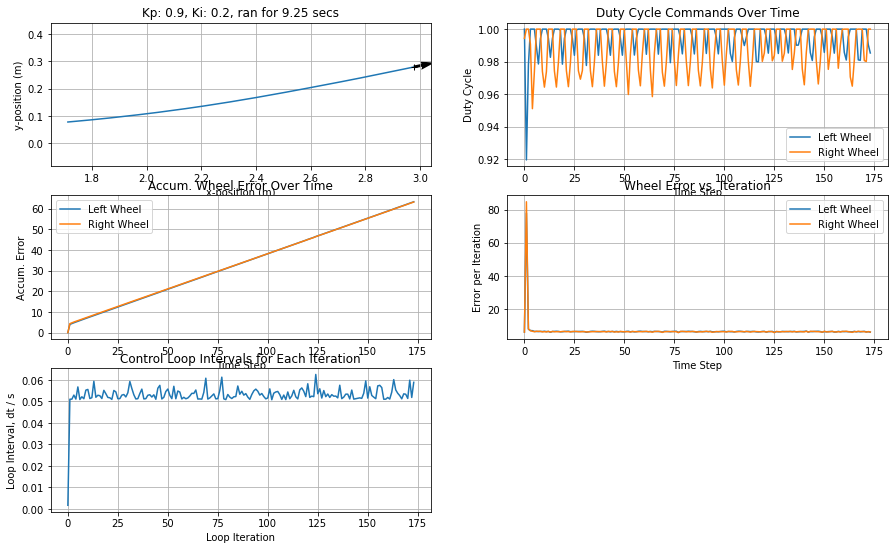

In [11]:
"""
This is the main control loop. What it does is it sets the desired linear and angular velocities, and then uses the drive method in the controller class to calculate the duty cycles for the left and right motors. 
- You'll notice that it sleeps for the dt value, which is how often the control loop runs. We can increase this (longer interval between control loop durations) to decrease the CPU load on the Pi, as then the control loop runs less often.
- First, it sets the desired linear and angular velocities. Then, it calculates the duty cycles for the left and right motors using the drive method in the controller class.
- It then updates the robot's pose, AKA drives the motor and makes it move, based on the duty cycles.

RUN THIS CELL, STOP IT AFTER A FEW SECONDS (10, 20, 30 seconds idk), and look at the graphs!
"""

"""
And so for whoever saw my message on Discord, the issue we're having is that for a given v_desired input, we're getting a much larger output from the motors. Like if we set v_desired to 0.5m/s, we get 2m/s. 
- The controller also seems to output the same duty cycle for both motors, even if the wheel velocities are different.
- The output duty cycles are also much too high. I don't know why the duty cycles are not being properly adjusted.
- I think the issue lies within the drive or the pid_control method of the RobotController class. 
- I thought the issue had something to do with how wheel velocity error is being used to scale duty cycle, but not sure.
- I also investigated and tried to double check if the units we're using are consistent and being converted to/from radians/sec to m/s correctly, but I couldn't find anything wrong.
- I also tried to see if the wheel velocities were being calculated correctly, and they seem to be.
- I also tried to see if the wheel velocities were being used correctly in the controller, and they seem to be.
- In conclusion, would love a second pair of eyes on this!

"""

# Main control loop

# Example: Move forward at 0.5 m/s with no rotation
v_desired = 0.5
w_desired = 0.0

# Controller Parameters
Kp = 0.9
Ki = 0.2
Kd = 0.0

# Initialising
controller = RobotController(Kp, Ki, Kd)

poses = []
velocities = []
duty_cycle_commands = []
error_sums = []
errors = []
actual_dts = []


start_time, last_time = time.time(), time.time()

try:
    while True: 
        current_time = time.time() # Get the current time. We need this to measure the actual amount of time that's elapsed since the last iteration of the control loop.
        actual_dt = current_time - last_time # This is the actual amount of time that elapsed since the last iteration of the control loop. Hence, allows us to get more accurate velocity calculations rather than relying on the robot's fixed dt value.

        # Calculate the duty cycles that we need to send to the motors in order to get our desired v_desired and w_desired
        duty_cycle_l, duty_cycle_r = controller.drive(v_desired, w_desired, robot.wl, robot.wr, actual_dt)

        print(f"v_des: {v_desired:.2f}, w_des: {w_desired:.2f}, v_actual: {robot.wl:.2f}, w_actual: {robot.wr:.2f}")
        print(f"duty cycle l: {duty_cycle_l:.2f}, r: {duty_cycle_r:.2f}")
        
        # Now, we send those duty cycle commands to the robot, and in return it gives us its updated x and y coordinate positions based on odometry info from the shaft encoders.
        x, y, th = robot.pose_update(duty_cycle_l, duty_cycle_r, actual_dt)
        
        # Log data
        # Here, I record and log everything so we can graph it.
        poses.append([x,y,th])
        duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
        velocities.append([robot.wl,robot.wr])
        error_sums.append([controller.e_sum_l, controller.e_sum_r])
        errors.append([controller.e_l_prev, controller.e_r_prev])
        actual_dts.append(actual_dt)
        
        print(f"Position: ({x:.2f}, {y:.2f}), Orientation: {th:.2f}\n")
        
        last_time = current_time
        time.sleep(robot.dt)

except KeyboardInterrupt:
    print("Stopping robot")
    robot.set_motor_speed(0, 0)
    end_time = time.time()
    duration = end_time - start_time


    # Plot robot data
#     display.clear_output(wait=True)
    plt.figure(figsize=(15,9))
    
    plt.subplot(3, 2, 1)
    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.title(f"Kp: {Kp}, Ki: {Ki}, ran for {duration:.2f} secs")
    plt.axis('equal')
    plt.grid()

    plt.subplot(3, 2, 2)
    duty_cycle_commands = np.array(duty_cycle_commands)
    plt.plot(duty_cycle_commands[:, 0], label='Left Wheel')
    plt.plot(duty_cycle_commands[:, 1], label='Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Duty Cycle')
    plt.title('Duty Cycle Commands Over Time')
    plt.legend() 
    plt.grid()
    
    plt.subplot(3, 2, 3)
    error_sums = np.array(error_sums)
    plt.plot(error_sums[:, 0], label='Left Wheel')
    plt.plot(error_sums[:, 1], label='Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Accum. Error')
    plt.title('Accum. Wheel Error Over Time')
    plt.legend() 
    plt.grid()
        
    plt.subplot(3, 2, 4)
    errors = np.array(errors)
    plt.plot(errors[:, 0], label='Left Wheel')
    plt.plot(errors[:, 1], label='Right Wheel')
    plt.xlabel('Time Step')
    plt.ylabel('Error per Iteration')
    plt.title('Wheel Error vs. Iteration')
    plt.legend() 
    plt.grid()
    
    plt.subplot(3, 2, 5)
    plt.plot(range(len(actual_dts)), actual_dts)
    plt.xlabel('Loop Iteration')
    plt.ylabel('Loop Interval, dt / s')
    plt.title('Control Loop Intervals for Each Iteration')
    plt.grid()
    
    display.display(plt.gcf())

#     GPIO.cleanup()

    """
    Hopefully the graphs are self explanatory. If not, please ask me. I'm happy to explain anything.
    """


In [7]:
    robot.set_motor_speed(0, 0)

In [8]:
###################

# Choose option 1 to have the motors turn and print out encoder steps.
# What you're looking for is:
# - The correct motor is spinning, i.e. only the left motor spins if you do robot.set_motor_speed(0, 1)
#     - If the wrong motor spins, check pin assignments.
# - The motor is spinning in the correct direction for the given velocity. e.g. Forwards for 1, backwards for -1.
#.    - To reverse direction, swap the IN1 / IN2 assignments or IN3 / IN4 assignments. 
# - The encoder values are correct for the given velocity. e.g. they should be counting upwards if velocity is positive.
#     - If encoder values are always 0, check that the motor cables are plugged in correctly.
#.    - If they're counting the wrong direction, you need to swap the ENC_A and ENC_B pin assignments for the appropriate encoder


# Choose option 2 to test the pose_update method


robot.ML_ENC.steps = 0
robot.MR_ENC.steps = 0

OPTION = 0






################

if OPTION==1:
    # First argument is the left motor, second argument is the right motor.
    robot.set_motor_speed(0.3, 0.3)


poses = []
velocities = []
duty_cycle_commands = []

if OPTION != 0:
    try:
        while True:
            if OPTION == 1:
                left_steps = robot.ML_ENC.steps
                right_steps = robot.MR_ENC.steps
                print(f"l: {left_steps}, r: {right_steps}")
                if abs(left_steps) >= MAX_ENC_STEPS-2 or abs(right_steps) >= MAX_ENC_STEPS-2:
                    robot.set_motor_speed(0, 0)
                    break
                wl, wr = robot.read_wheel_velocities()
                print(f"wl: {wl}, wr: {wr}")

            elif OPTION == 2:
                x, y, th = robot.pose_update(1, 1)
                poses.append([x,y,th])
                velocities.append([robot.wl,robot.wr])
                print(f"x:{x:.2f}, y:{y:.2f}, th: {th:.2f}\n")

            time.sleep(robot.dt)


    except KeyboardInterrupt:
        print("Stopping robot")
        robot.set_motor_speed(0, 0)

In [9]:
# plt.figure(figsize=(15,9))

graph = False

if graph:

    # Plot robot data
    plt.clf()
    plt.figure()

    plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
    # plt.plot(x,y,'k',marker='+')
    plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
    # plt.plot(goal_x,goal_y,'x',markersize=5)
    # plt.quiver(goal_x,goal_y,0.1*np.cos(goal_th),0.1*np.sin(goal_th))
    # plt.xlim(-1,1)
    # plt.ylim(-1,1)
    plt.xlabel('x-position (m)')
    plt.ylabel('y-position (m)')
    plt.grid()


    plt.figure()
    plt.subplot(1,2,1)
    plt.plot(range(len(np.array(velocities)[:,0])),np.array(velocities)[:,0])
    plt.subplot(1,2,2)
    plt.plot(range(len(np.array(velocities)[:,1])),np.array(velocities)[:,1])


    # plt.subplot(2,2,2)
    # plt.plot(np.arange(i+1)*robot.dt,np.array(duty_cycle_commands))
    # plt.xlabel('Time (s)')
    # plt.ylabel('Duty cycle')
    # plt.grid()

    # plt.subplot(2,2,4)
    # for i in range(300):
    #     plt.plot(np.arange(i+1)*robot.dt,np.array(velocities))

    #     plt.xlabel('Time (s)')
    # plt.ylabel('Wheel $\omega$')
    # plt.legend(['Left wheel', 'Right wheel'])
    # plt.grid()


    # display.clear_output(wait=True)
    display.display(plt.gcf())



In [10]:
# # Real time, updating graphs. 
# # Do not use for now, interferes with velocity control.

# plt.figure(figsize=(15,9))


# # Example: Move forward at 0.5 m/s with no rotation
# Kp = 0.6
# Ki = 0.0

# v_desired = 0.5
# w_desired = 0.0


# # Vars
# poses = []
# velocities = []
# duty_cycle_commands = []
# errors = []
# actual_dts = []
# i = 0
# controller = RobotController(Kp, Ki)
# start_time, last_time = time.time(), time.time()

# try:
#     while True:        
#         # Example motion using controller 

# #         if i < 100: # drive in circular path (turn left) for 10 s
# #             duty_cycle_l,duty_cycle_r = controller.drive(0.1,1,robot.wl,robot.wr)
# #         elif i < 200: # drive in circular path (turn right) for 10 s
# #             duty_cycle_l,duty_cycle_r = controller.drive(0.1,-1,robot.wl,robot.wr)
# #         else: # stop
# #             duty_cycle_l,duty_cycle_r = (0,0)

#         # Simulate robot motion - send duty cycle command to robot
# #         x,y,th = robot.pose_update(duty_cycle_l,duty_cycle_r)

#         current_time = time.time()
#         actual_dt = current_time - last_time

#         duty_cycle_l, duty_cycle_r = controller.drive(v_desired, w_desired, robot.wl, robot.wr, actual_dt)
#         x, y, th = robot.pose_update(duty_cycle_l, duty_cycle_r, actual_dt)
      
        
#         # Log data
#         poses.append([x,y,th])
#         duty_cycle_commands.append([duty_cycle_l,duty_cycle_r])
#         velocities.append([robot.wl,robot.wr])
#         errors.append([controller.e_sum_l, controller.e_sum_r])
#         actual_dts.append(actual_dt)

#         # Plot robot data
#         plt.clf()
#         plt.cla()
#         plt.subplot(1,3,1)
#         plt.plot(np.array(poses)[:,0],np.array(poses)[:,1])
#         plt.plot(x,y,'k',marker='+')
#         plt.quiver(x,y,0.1*np.cos(th),0.1*np.sin(th))
# #         plt.xlim(-1,1)
# #         plt.ylim(-1,1)
#         plt.xlabel('x-position (m)')
#         plt.ylabel('y-position (m)')
#         plt.grid()

#         plt.subplot(3,2,2)
#         plt.plot(np.arange(i+1)*robot.dt,np.array(duty_cycle_commands))
#         plt.xlabel('Time (s)')
#         plt.ylabel('Duty cycle')
#         plt.grid()

#         plt.subplot(3,2,4)
#         plt.plot(np.arange(i+1)*robot.dt,np.array(velocities))
#         plt.xlabel('Time (s)')
#         plt.ylabel('Wheel $\omega$')
#         plt.legend(['Left wheel', 'Right wheel'])
#         plt.grid()

#         plt.subplot(3,2,6)
#         plt.plot(np.arange(i+1)*robot.dt,np.array(actual_dts))
#         plt.xlabel('Time (s)')
#         plt.ylabel('Loop Iteration Duration')
#         plt.grid()

#         display.clear_output(wait=True)
#         display.display(plt.gcf())
        
#         i += 1
#         last_time = current_time
#         time.sleep(robot.dt)

        
# except KeyboardInterrupt:
#     print("Stopping robot")
#     robot.set_motor_speed(0, 0)